# Orbit Integration

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Setup" data-toc-modified-id="Setup-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Setup</a></span></li><li><span><a href="#Integration-run" data-toc-modified-id="Integration-run-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Integration run</a></span></li><li><span><a href="#Results-from-the-simulation-dataset" data-toc-modified-id="Results-from-the-simulation-dataset-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Results from the simulation dataset</a></span></li><li><span><a href="#Plots" data-toc-modified-id="Plots-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Plots</a></span></li><li><span><a href="#Analysis" data-toc-modified-id="Analysis-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Analysis</a></span></li></ul></div>

## Setup

In [58]:
import numpy as np
from numpy.linalg import norm

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rcParams
%matplotlib inline

In [35]:
from galaxy.m33analyticorbit import M33AnalyticOrbit
from galaxy.timecourse import TimeCourse

In [88]:
filename = './orbits.txt' # for output
orb = M33AnalyticOrbit(filename)

## Integration run

In [91]:
# integrate and write data file
dt = 0.001 # Gyr
orb.orbit_integrator(dt, t_max=12)

In [92]:
# read the file back in
data = np.genfromtxt(filename, dtype=None, names=True, skip_header=0)

data.shape

(12002,)

In [93]:
# get the positions in a (3, N) array
xyz = np.array([data[xi] for xi in ('x','y','z')])
vxyz = np.array([data[vxi] for vxi in ('vx','vy','vz')])

In [94]:
# get separations and velocity magnitudes
r = norm(xyz, axis=0)
v = norm(vxyz, axis=0)
t = data['t']

## Results from the simulation dataset

Recreates the results in Hwk 6. However, these CoM's have all been calculated previously and store in postgres, so just fetch them from the database.

In [95]:
# my non-standard class
tc = TimeCourse()

# the next 2 lines only work on my machine, as it needs the postgres database
M33 = tc.read_com_db(galaxy='M33')
M31 = tc.read_com_db(galaxy='M31')

# other people can use these variants, with the `com_{galname}.txt` files in the `data/` folder
# M33 = tc.read_com_file(galaxy='M33')
# M31 = tc.read_com_file(galaxy='M31')

# need the time values, not the same length as the sim values
t_sim = M33['t']

# calculating separations and velocities is essentially the same as before
xyz_sim = np.array([M33[xi] for xi in ('x','y','z')]) - \
            np.array([M31[xi] for xi in ('x','y','z')])
r_sim = norm(xyz_sim, axis=0)

vxyz_sim = np.array([M33[vxi] for vxi in ('vx','vy','vz')]) - \
            np.array([M31[vxi] for vxi in ('vx','vy','vz')])
v_sim = norm(vxyz_sim, axis=0)

r_sim.shape, v_sim.shape

((802,), (802,))

## Plots

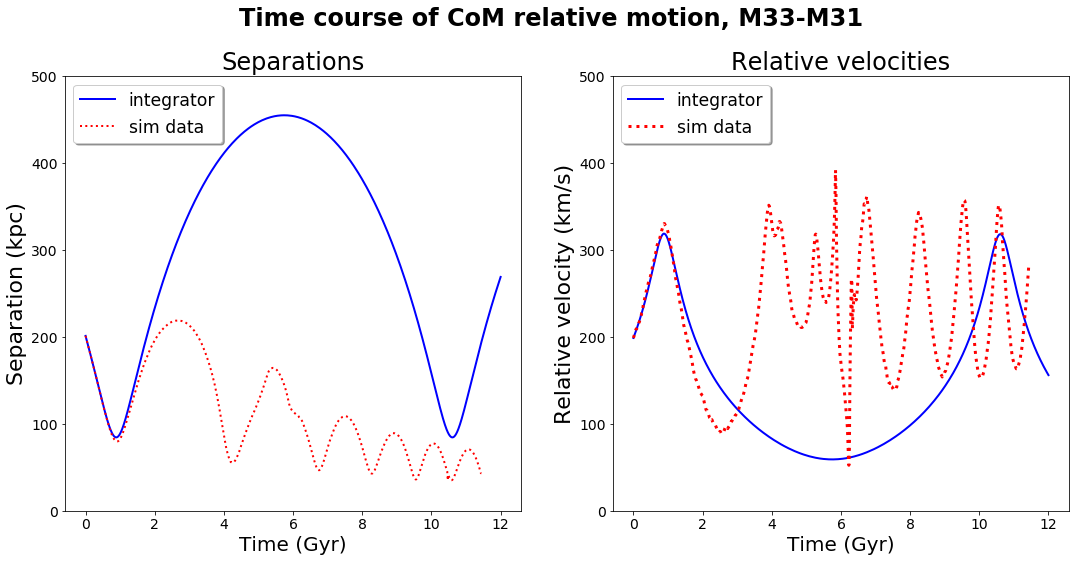

In [96]:
fig = plt.figure(figsize=(18,8))
subplots = (121, 122)

# set up the left subplot
ax0 = plt.subplot(121)

# add the curves
ax0.plot(t, r, 'b-', lw=2, label='integrator')
ax0.plot(t_sim, r_sim, 'r:', lw=2, label='sim data')

# Add labels and subplot title
ax0.set_xlabel('Time (Gyr)', fontsize=20)
ax0.set_ylabel('Separation (kpc)', fontsize=22)
ax0.legend(loc='upper left',fontsize='xx-large', shadow=True)
ax0.set_title('Separations', fontsize=24)

#set axis limits
ax0.set_ylim(0, 500)

# set up the right subplot
ax1 = plt.subplot(122)

# add the curves
ax1.plot(t, v, 'b-', lw=2, label='integrator')
ax1.plot(t_sim, v_sim, 'r:', lw=3, label='sim data')

#adjust tick label font size
label_size = 14
rcParams['xtick.labelsize'] = label_size 
rcParams['ytick.labelsize'] = label_size

# Add labels and subplot title
ax1.set_xlabel('Time (Gyr)', fontsize=20)
ax1.set_ylabel('Relative velocity (km/s)', fontsize=22)
ax1.legend(loc='upper left',fontsize='xx-large', shadow=True)
ax1.set_title('Relative velocities', fontsize=24)

#set axis limits
ax1.set_ylim(0, 500)

# Overall title
fig.suptitle(f'Time course of CoM relative motion, M33-M31', y=1.0, fontsize=24, weight='bold');

## Analysis

The integrator starts out pretty close to the full simulation until almost 2 Gyr, then diverges dramatically. It looks as though M33 is on a long-period and highly elliptical orbit around M31.

Several potentially important things are missing from the orbit integration in the homework:
1. Dynamical friction, as M33 comes close to the other objects. This applies particularly to the DM halos, which are more likely to overlap than the stars.
2. The effects of the MW, which by 3 Gyr is approaching rapidly and by 6 Gyr is merged with M31.
3. M31 is treated as a disk throughout, which is a bad approximation by 6 Gyr. At later timepoints the merged galaxy is closer to elliptical (though traixial and with some rotation).

__How to include the MW?__

As a relatively easy first step, use the MW CoM positions that we already know and add a `MW_accel()` method to the class. That at least gives us a better central mass for M33 to orbit around, and a shorter orbital period.

Dynamical friction is not so easy (point 1). 

For point 3, we might be able to do something with shapes (e.g. using `hernquist_accel()` rather than `miyamoto_nagai_accel()` for M31 and MW disk particles at later timepoints, but without much confidence in the answers.